In [6]:
import tensorflow as tf
import numpy as np
from utils.audio_tools import create_audio_player
from librosa import load
import utils.constants as consts
from tensorflow.keras.models import Model, load_model
from typing import List
from tensorflow import Tensor
from utils.audio_tools import convert_signal_into_mel_spectrogram
from utils.displays import display_mel_spectrogram
import IPython.display as display


PATH_TO_SAMPLE: str = '../long-audio/break_beat_1.wav'
PATH_TO_MODEL: str = '../runs/models/model_3/epoch-96.pb'

<Figure size 432x288 with 0 Axes>

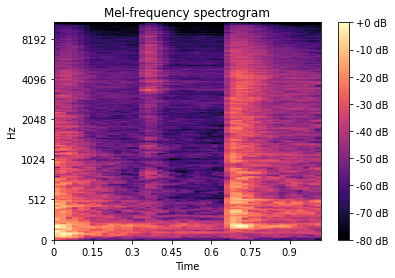

In [7]:
from librosa.util import normalize

signal: np.ndarray = load(PATH_TO_SAMPLE, sr=consts.SAMPLE_RATE, duration=1)[0]
signal = normalize(signal)

mel_spec: np.ndarray = convert_signal_into_mel_spectrogram(signal).reshape(consts.X_SHAPE)

create_audio_player(mel_spec, normalize=True)
display_mel_spectrogram(mel_spec)

In [4]:
base_model: Model = load_model(PATH_TO_MODEL)

['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9']

In [31]:
names: List[str] = ['conv2d_9']
layers: List[Model] = [base_model.get_layer(name).output for name in names]
dream_model = Model(inputs=base_model.input, outputs=layers)

In [32]:
def calc_loss(_signal, model):
    """
    :param _signal:
    :param model:
    :return:
    """

    signal_batch: Tensor = tf.expand_dims(_signal, axis=0)
    layer_activations = model(signal_batch)

    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses: List[Tensor] = []
    for activation in layer_activations:
        loss = tf.math.reduce_mean(activation)
        losses.append(loss)

    return tf.reduce_sum(losses)


class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[300, 44, 1], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)

      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          tape.watch(img)
          loss = calc_loss(img, self.model)

        gradients = tape.gradient(loss, img)
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img


deepdream = DeepDream(dream_model)

In [33]:
def run_deep_dream_simple(_signal: np.ndarray, steps: int = 5, step_size: float = 0.01):
    """
    :param _signal:
    :param steps:
    :param step_size:
    :return:
    """

    _signal: Tensor = tf.convert_to_tensor(_signal)
    step_size: Tensor = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0

    while steps_remaining:

        if steps_remaining > 100:
            run_steps = tf.constant(100)

        else:
            run_steps = tf.constant(steps_remaining)

        steps_remaining -= run_steps
        step += run_steps

        loss, _signal = deepdream(_signal, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        display_mel_spectrogram(_signal)
        print(f'Step: {step} \nLoss: {loss}')

    display.clear_output(wait=True)
    display_mel_spectrogram(_signal)

    return _signal

<Figure size 432x288 with 0 Axes>

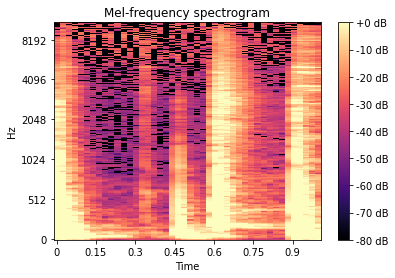

In [48]:
dreamed_signal = run_deep_dream_simple(_signal=mel_spec, steps=1, step_size=0.001)

(300, 44, 1)


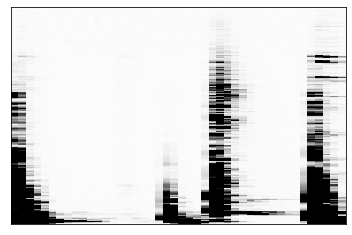

In [50]:
from librosa.display import specshow


dreamed_signal_np: np.ndarray = dreamed_signal.numpy()
print(dreamed_signal_np.shape)
specshow(dreamed_signal_np.reshape(300, 44), sr=consts.SAMPLE_RATE, cmap='binary')
create_audio_player(dreamed_signal.numpy())